# Análise Orçamentária e Forecast — Visão FP&A
Este notebook tem como objetivo simular uma análise padrão de FP&A com base em dados fictícios contendo Orçado, Realizado e Forecast para diferentes departamentos ao longo de 12 meses.

A análise responde perguntas como:
- Estamos dentro do orçamento?
- O forecast atual reflete a realidade?
- Há sazonalidade nas despesas?
- Quais áreas estão mais distantes da meta?

Dados simulados no arquivo: `dados/orcamento_empresa.csv`

#### Importando os Dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../dados/orcamento_empresa.csv")

# Cálculos adicionais
df["Desvio_Real"] = df["Realizado"] - df["Orcado"]
df["Desvio_Forecast"] = df["Forecast"] - df["Orcado"]
df["Gap Forecast vs Real"] = df["Forecast"] - df["Realizado"]
df["Execucao %"] = df["Realizado"] / df["Orcado"] * 100

#### Visão Geral Agregada

In [26]:
# Totais agregados
resumo = df[["Orcado", "Realizado", "Forecast"]].sum()
resumo["Desvio Real (%)"] = (resumo["Realizado"] - resumo["Orcado"]) / resumo["Orcado"] * 100
resumo["Desvio Forecast (%)"] = (resumo["Forecast"] - resumo["Orcado"]) / resumo["Orcado"] * 100
display(
    resumo.to_frame()
          .T
          .reset_index(drop=True)
          .style
          .format("{:,.2f}")
          .hide(axis="index")
)

Orcado,Realizado,Forecast,Desvio Real (%),Desvio Forecast (%)
"1,335,848.25","1,306,946.18","1,340,474.28",-2.16,0.35


#### Desempenho por Departamento

In [6]:
# Execução e desvios por área
df_dept = df.groupby("Departamento")[["Orcado", "Realizado", "Forecast", "Desvio_Real"]].sum()
df_dept["Execução %"] = df_dept["Realizado"] / df_dept["Orcado"] * 100
df_dept.sort_values("Execução %", ascending=False)

,Orcado,Realizado,Forecast,Desvio_Real,Execução %
Departamento,,,,,
RH,191381.92,195261.44,185940.14,3879.52,102.027109
Operações,290912.50,285308.52,294693.27,-5603.98,98.073654
Marketing,287742.93,281259.14,278900.21,-6483.79,97.746673
TI,256962.36,248853.50,261850.81,-8108.86,96.844339
Financeiro,308848.54,296263.58,319089.85,-12584.96,95.925200


#### Análise Temporal (Orçado vs Realizado vs Forecast)

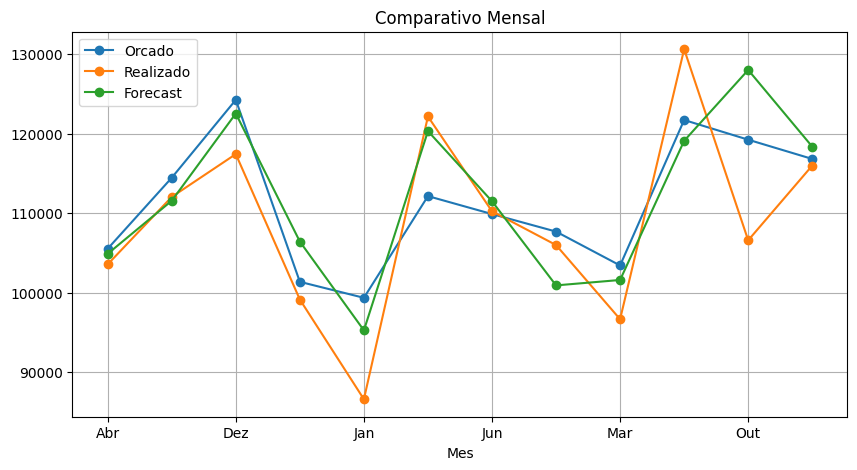

In [7]:
# Gráfico por mês
df_mes = df.groupby("Mes")[["Orcado", "Realizado", "Forecast"]].sum()
df_mes.plot(kind="line", marker='o', figsize=(10,5), title="Comparativo Mensal")
plt.grid()
plt.show()

#### Tendência com Média Móvel

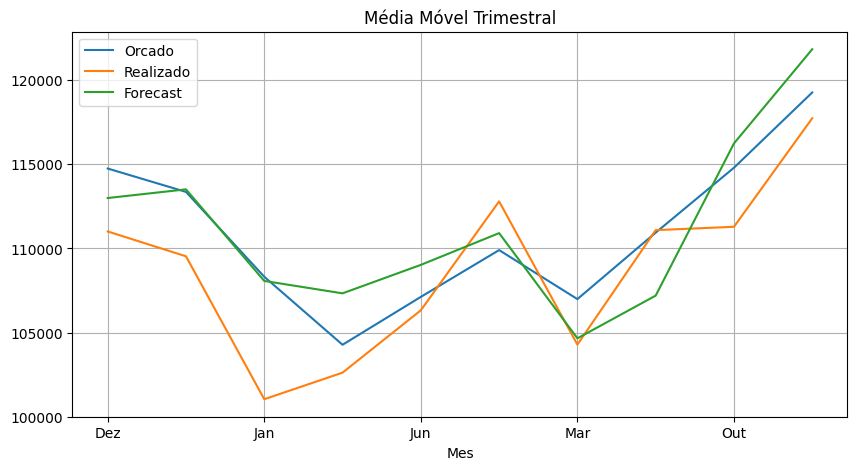

In [8]:
# Rolling average
df_mes.rolling(window=3).mean().plot(figsize=(10,5), title="Média Móvel Trimestral")
plt.grid()
plt.show()

#### Ranking de Desvios

In [ ]:
# Maiores estouros e sobras
top_sobras = df.sort_values("Desvio_Real", ascending=False).head(5)
top_estouros = df.sort_values("Desvio_Real").head(5)

colunas_formatar2= top_sobras.columns.difference(["Ano", "Departamento", "Mes"])

display(
    top_sobras
    .reset_index(drop=True)
    .style
    .format({col: "{:,.2f}" for col in colunas_formatar2)
    .hide(axis="index")
)

display(
    top_estouros
    .reset_index(drop=True)
    .style
    .format({col: "{:,.2f}" for col in colunas_formatar2)
    .hide(axis="index")
)

Ano,Departamento,Mes,Orcado,Realizado,Forecast,Desvio_Real,Desvio_Forecast,Gap Forecast vs Real,Execucao %
2024,TI,Nov,"23,730.83","30,207.01","26,194.38","6,476.18","2,463.55","-4,012.63",127.29
2024,RH,Jun,"15,856.94","20,263.77","13,609.15","4,406.83","-2,247.79","-6,654.62",127.79
2024,Financeiro,Jul,"25,967.42","30,354.55","29,044.85","4,387.13","3,077.43","-1,309.70",116.89
2024,TI,Set,"22,638.17","26,938.71","24,769.76","4,300.54","2,131.59","-2,168.95",119.00
2024,Operações,Ago,"24,613.83","28,729.42","24,964.94","4,115.59",351.11,"-3,764.48",116.72


Ano,Departamento,Mes,Orcado,Realizado,Forecast,Desvio_Real,Desvio_Forecast,Gap Forecast vs Real,Execucao %
2024,Operações,Dez,"25,677.08","17,711.55","26,368.11","-7,965.53",691.03,"8,656.56",68.98
2024,TI,Out,"23,178.06","15,681.78","26,138.72","-7,496.28","2,960.66","10,456.94",67.66
2024,Financeiro,Ago,"26,640.78","19,323.46","27,847.66","-7,317.32","1,206.88","8,524.20",72.53
2024,TI,Mar,"19,652.89","13,378.10","22,180.38","-6,274.79","2,527.49","8,802.28",68.07
2024,RH,Jan,"15,064.00","9,436.97","12,330.44","-5,627.03","-2,733.56","2,893.47",62.65


#### Heatmap de Desvios

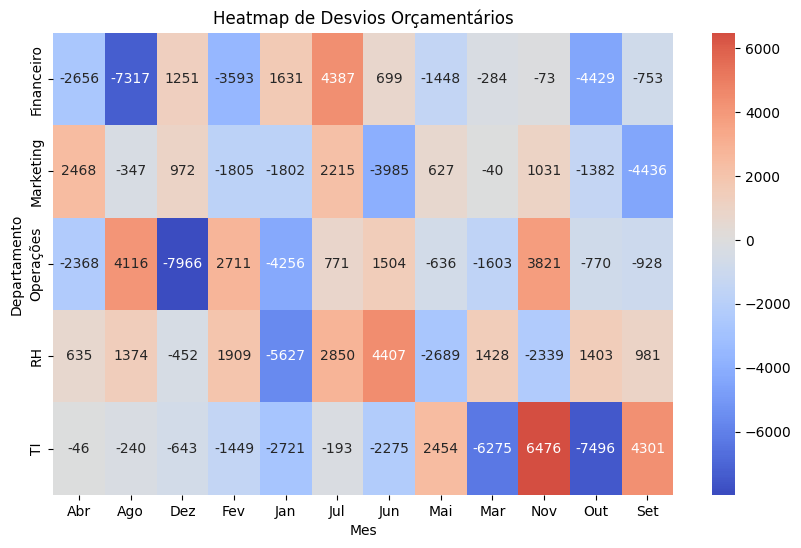

In [11]:
pivot = df.pivot(index="Departamento", columns="Mes", values="Desvio_Real")
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm", center=0)
plt.title("Heatmap de Desvios Orçamentários")
plt.show()

#### Alertas: Forecast vs Real

In [35]:
# Quais áreas estão mais distantes do que previam?
gap_ranking = df.sort_values("Gap Forecast vs Real", ascending=False)

# Selecionar apenas colunas numéricas (ignorando texto)
colunas_formatar3= gap_ranking.columns.difference(["Ano", "Departamento", "Mes"])

display(
    gap_ranking
    .head(5)
    .reset_index(drop=True)
    .style
    .format({col: "{:,.2f}" for col in colunas_formatar3})
    .hide(axis="index")
)


Ano,Departamento,Mes,Orcado,Realizado,Forecast,Desvio_Real,Desvio_Forecast,Gap Forecast vs Real,Execucao %
2024,TI,Out,"23,178.06","15,681.78","26,138.72","-7,496.28","2,960.66","10,456.94",67.66
2024,TI,Mar,"19,652.89","13,378.10","22,180.38","-6,274.79","2,527.49","8,802.28",68.07
2024,Operações,Dez,"25,677.08","17,711.55","26,368.11","-7,965.53",691.03,"8,656.56",68.98
2024,Financeiro,Ago,"26,640.78","19,323.46","27,847.66","-7,317.32","1,206.88","8,524.20",72.53
2024,Financeiro,Fev,"22,847.48","19,254.06","27,130.80","-3,593.42","4,283.32","7,876.74",84.27


## Conclusão

- A execução orçamentária geral foi positiva, com gasto 2,16% abaixo do orçamento.
- O forecast se mostrou aderente ao total, mas com falhas em capturar variações mensais.
- Destaques negativos: estouros em Dez (Operações), Out (TI), Mar (RH).
- Financeiro teve sobras expressivas — oportunidade para realocação de verba?
- O heatmap revelou padrões sazonais relevantes, úteis para o planejamento futuro.
- Recomendação: fortalecer o processo de revisão do forecast e analisar desvios críticos com maior profundidade.